In [19]:
# importing all necessary modules
from operator import index
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec
import pandas as pd
import json
from sklearn.decomposition import PCA
from os.path import exists
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import BisectingKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import re
from sklearn.preprocessing import StandardScaler, normalize
import pickle

In [20]:
# if(not exists('data/templates.txt')):
# 	f = open('data/templates.json')
# 	f1 = open('data/templates.txt', 'w')
# 	data = json.load(f)
# 	for i in data.items():
# 		f1.write(i[1])
# 		f1.write("\n")
# 	f.close()
# 	f1.close()

sample = open("../LogClass/data/intern/FP1/preprocessed_logs_word.txt")
f = sample.readlines()

# Replaces escape character with space
#f = s.replace("\n", " ")

In [21]:
data = []

# iterate through each sentence in the file
for i in f:
	temp = []
	# tokenize the sentence into words
	for j in word_tokenize(i):
		temp.append(j.lower())
	data.append(temp)

In [22]:
len(data)

18842

### CBOW MODEL

In [23]:
# Create CBOW model
print('CBOW: ')
model1 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100, window = 5)
model1.build_vocab(data, progress_per=1000)
model1.train(data, total_examples=model1.corpus_count, epochs=model1.epochs)

CBOW: 


(243539, 556215)

In [24]:
newData = []
for i, sent in enumerate(data):
    vector = [0]*100
    for j, word in enumerate(sent):
        vector+=model1.wv[word]
        #print(vector)
        #data[i][j] = model1.wv[word]
    newData.append(vector)

In [25]:
len(newData),newData

(18842,
 [array([-4.53623593e-01,  1.66450059e+00,  8.10721934e-01,  1.14280117e+00,
         -5.32998800e-01, -2.04718709e+00,  3.69499922e-01,  1.98107672e+00,
         -1.30751061e+00, -1.19293380e+00,  8.27758789e-01, -1.54486883e+00,
         -4.51417446e-01,  1.10437667e+00, -1.38757035e-01,  3.12569618e-01,
          1.45577574e+00,  2.36807346e-01, -5.74257076e-01, -2.62556100e+00,
          1.04988635e+00,  5.63394845e-01,  9.53562915e-01, -1.04065597e+00,
          2.99706906e-01, -5.17341271e-02, -1.12488389e+00,  1.04174829e+00,
         -3.55764896e-01, -5.75330913e-01, -2.88165629e-01, -1.08181000e-01,
          1.02701521e+00, -8.95287097e-01, -4.03091013e-01,  8.68078053e-01,
          2.03030634e+00,  1.48332626e-01, -4.04896885e-01,  2.13636428e-01,
          6.20179117e-01, -6.80487573e-01, -1.13417649e+00,  6.41725659e-01,
          3.60826612e-01,  5.49087167e-01, -1.59587860e+00, -3.89889203e-04,
          4.51721907e-01,  7.69923866e-01,  1.80384852e-02,  1.25120

In [26]:
# saving model
model1.save("data/CBOW_APP1.model")

Text(0.5, 1.0, 'Visualising the data')

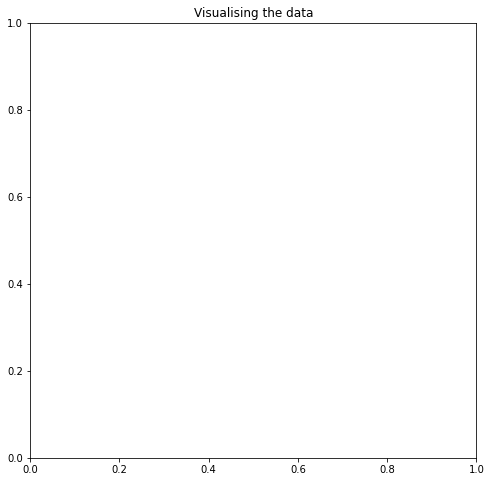

In [27]:
# clustering
vectors = newData

scaler = StandardScaler()
X_scaled = scaler.fit_transform(vectors)
X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)

pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

plt.figure(figsize =(8, 8), facecolor='w')
plt.title('Visualising the data')

In [28]:
# saving scalar & PCA
with open('data/scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)
with open('data/pca.pickle', 'wb') as f:
    pickle.dump(pca, f)

In [29]:
import numpy as np
from scipy.spatial.distance import cdist

np.random.seed(6)

In [30]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = BisectingKMeans(n_clusters=k).fit(X_principal)
    kmeanModel.fit(X_principal)
  
    distortions.append(sum(np.min(cdist(X_principal, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_principal.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X_principal, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_principal.shape[0]
    mapping2[k] = kmeanModel.inertia_

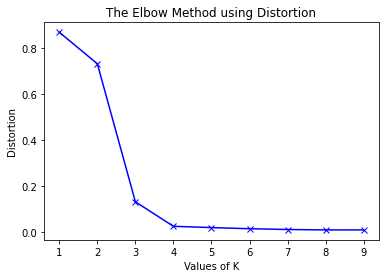

In [31]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

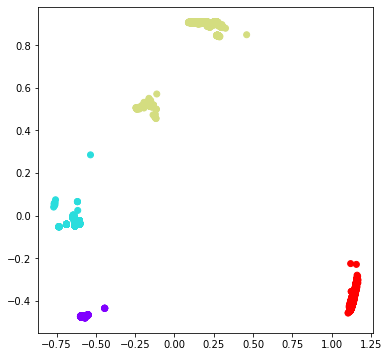

In [32]:
# x = silhouette_scores.index(max(silhouette_scores)) + 2

# ac = AgglomerativeClustering(n_clusters = x)
ac  = BisectingKMeans(n_clusters=4)
plt.figure(figsize =(6, 6), facecolor='w')
plt.scatter(X_principal['P1'], X_principal['P2'],
            c = ac.fit_predict(X_principal), cmap ='rainbow')
plt.show()

In [33]:
# saving clustering
with open('data/ac.pickle', 'wb') as f:
    pickle.dump(ac, f)

In [34]:
len(X_principal['P1'])

18842

### SKIP GRAM

In [35]:
# Create Skip Gram model
print('\nSKIP GRAM: ')
model2 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100, window = 5, sg=1)
model2.build_vocab(data, progress_per=1000)
model2.train(data, total_examples=model1.corpus_count, epochs=model1.epochs)


SKIP GRAM: 


(243063, 556215)

In [36]:
# clustering
vectors = model2.wv.vectors

scaler = StandardScaler()
X_scaled = scaler.fit_transform(vectors)
X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)

pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

plt.figure(figsize =(8, 8), facecolor='w')
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

In [37]:
# agglomerative clustering
k = []
ac = []
silhouette_scores = []

for i in range(2, 10):
        k.append(i)
        ac.append(BisectingKMeans(n_clusters = i))
        silhouette_scores.append(
                silhouette_score(X_principal, ac[i-2].fit_predict(X_principal)))
  
# Plotting a bar graph to compare the results
plt.figure(facecolor='w')
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

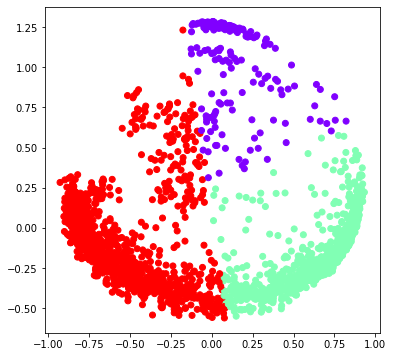

In [ ]:
x = silhouette_scores.index(max(silhouette_scores)) + 2
ac1 = BisectingKMeans(n_clusters = x)

plt.figure(figsize =(6, 6), facecolor='w')
plt.scatter(X_principal['P1'], X_principal['P2'],
            c = ac1.fit_predict(X_principal), cmap ='rainbow')
plt.show()

In [ ]:
with open('data/SG_APP1_ac.pickle', 'wb') as f:
    pickle.dump(ac1, f)

In [ ]:
# saving model
model2.save("data/SG_APP1.model")